# A как же нам кормить сетку данными

In [6]:
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 519.5MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58f1c000 @  0x7fe9c277b2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 3.8MB/s 
    100% |████████████████████████████████| 2.0MB 10.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
from skimage import io,transform
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import random
import torchvision.transforms as transforms

наверная было бы удобно иметь какую нить абстракцию для этого

In [0]:
class DirectoryDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        data=[];
        self.classes=os.listdir(root_dir);
        for dir in self.classes:
            image_paths=os.listdir(os.path.join(root_dir,dir))
            data=data+[(os.path.join(root_dir,dir,x),dir) for x in image_paths]
        self.data=data;
        random.shuffle(self.data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image = io.imread(self.data[idx][0])

        if self.transform!=None:
            return self.transform((image,self.data[idx][1]))
        return image,self.data[idx][1]

Так а где сами данные?

In [1]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -O /tmp/ants.zip
!unzip -q /tmp/ants.zip -d content

--2018-10-31 13:53:17--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.118.86, 54.230.118.236, 54.230.118.183, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.118.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘/tmp/ants.zip’

/tmp/ants.zip       100%[===================>]  45.10M  2.94MB/s    in 16s     

2018-10-31 13:53:33 (2.78 MB/s) - ‘/tmp/ants.zip’ saved [47286322/47286322]



Поправим чуть чуть установленные модули

In [11]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

    100% |████████████████████████████████| 5.6MB 6.2MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.3MB 5.9MB/s 


ModuleNotFoundError: ignored

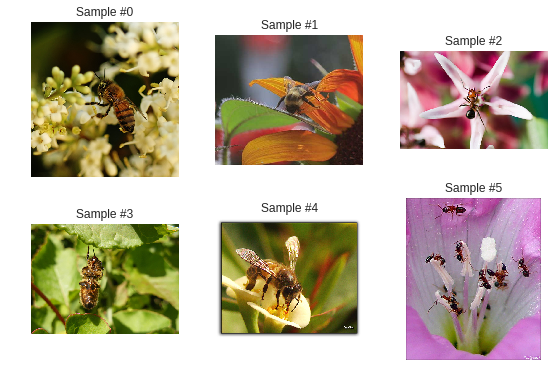

In [12]:
d=DirectoryDataset("content/hymenoptera_data/train")
#plt.ion()
fig = plt.figure()

for i in range(6):
    sample = d[i][0]
    ax = plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample)

plt.show()

# Давайте теперь по трансформируем данные

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return img

In [0]:
class RandomCrop(object):

    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]
        return image

In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __init__(self):
        pass

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = sample.transpose((2, 0, 1))
        return torch.from_numpy(image)



А теперь мы их скомбинируем

In [0]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])


И посмотрим как все это выглядит

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


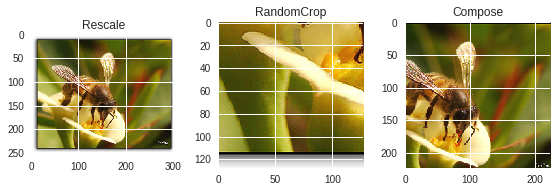

In [17]:
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = d[4][0]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample)

plt.show()

Но у нас же есть еще и значения которые нужно предсказывать

In [0]:
class TupleOp(object):

    def __init__(self,left,right):
        self.left=left;
        self.right=right;

    def __call__(self,sample):
        return (self.left(sample[0]),self.right(sample[1]))

class LabelToTensor(object):
    def __init__(self,labels):
        self.labels={};
        for i in range(len(labels)):
            self.labels[labels[i]]=i;


    def __call__(self,label):
        r=np.zeros((len(self.labels)),np.float32)
        r[self.labels[label]]=1.0;
        return torch.from_numpy(r)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224),ToTensor()])
d.transform=TupleOp(composed,LabelToTensor(d.classes))


In [24]:
for i in range(len(d)):
    sample = d[i]

    print(i, sample[0].size(), sample[1].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([2])
1 torch.Size([3, 224, 224]) torch.Size([2])
2 torch.Size([3, 224, 224]) torch.Size([2])
3 torch.Size([3, 224, 224]) torch.Size([2])


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# А теперь нам нужен еще батчинг и фоновая загрузка welcome DataLoader

In [26]:
dataloader = DataLoader(d, batch_size=4,
                        shuffle=True, num_workers=4)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched[0].size(),
           sample_batched[1].size())
    if i>10: break

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
4 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])
5 torch.Size([4, 3, 224, 224]) torch.Size([4, 2])


OSError: ignored

А попробуйте теперь поправить код так что бы он не взрывался когда и если картинка не находится